## Import Libraries

In [2]:
import os
import pandas as pd

import psycopg2

## Connect to the DB

In [3]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'omop_cdm'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

## Read cohort

In [4]:
cohortQuery = """select * from sepsis_icd.cohort;"""
cohortDf = pd.read_sql_query(cohortQuery, con)
cohortDf

,visit_occurrence_id,person_id,sepsis
0,-2147462198,-421334407,1
1,-2147304039,1052438339,1
2,-2147110420,-322699580,1
3,-2147002424,-1242295740,1
4,-2146865542,-2139970486,1
...,...,...,...
38079,852091286,-565257984,0
38080,1522522265,1197088962,0
38081,-1199008181,1846272996,0
38082,-1413882544,1379728849,0


## Cohort counts

In [5]:
cohortCountsQuery = """
    with t1 as (
        select
        sepsis,
        count(distinct visit_occurrence_id) as visit_occurrence_count,
        count(distinct person_id) as person_count
        from
        sepsis_icd.cohort
        group by sepsis
    )
    select sepsis, visit_occurrence_count as cnt, 'visit_occurrence_count' as entity from t1
    union
    select sepsis, person_count as cnt, 'person_count' as entity from t1
    ;
"""
cohortCountsDf = pd.read_sql_query(cohortCountsQuery, con)
cohortCountsDf

,sepsis,cnt,entity
0,0,19042,visit_occurrence_count
1,1,19042,visit_occurrence_count
2,0,13171,person_count
3,1,15668,person_count


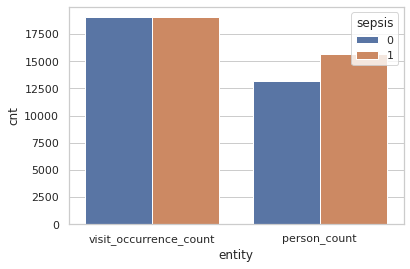

In [6]:
import seaborn as sns

sns.set_theme(style="whitegrid")
ax = sns.barplot(x='entity', y="cnt", hue='sepsis', data=cohortCountsDf)

## Static data

In [7]:
staticQuery = """select * from sepsis_icd.static;"""
staticDf = pd.read_sql_query(staticQuery, con)
staticDf

,person_id,visit_start_datetime,visit_end_datetime,visit_occurrence_id,visit_occurrence_concept_name,visit_duration_hrs,visit_source_concept_name,admitting_source_value
0,-45407753,2128-08-16 20:08:00,2128-09-01 12:25:00,1661230940,Emergency Room - Hospital,376.0,DIRECT EMER.,PHYSICIAN REFERRAL
1,-688080236,2119-04-27 07:15:00,2119-05-02 15:45:00,-930244224,Ambulatory Surgical Center,128.0,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL
2,586098445,2143-02-19 07:15:00,2143-03-02 13:50:00,-166442621,Ambulatory Surgical Center,270.0,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL
3,-2090043093,2157-07-22 07:15:00,2157-07-23 14:55:00,-980240395,Ambulatory Surgical Center,31.0,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL
4,-1802428568,2119-07-26 07:15:00,2119-07-29 15:40:00,-1963238015,Ambulatory Surgical Center,80.0,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL
...,...,...,...,...,...,...,...,...
38079,514388861,2188-07-14 15:56:00,2188-07-20 18:16:00,1940413172,Emergency Room - Hospital,146.0,DIRECT EMER.,PHYSICIAN REFERRAL
38080,-2046241961,2190-05-07 15:25:00,2190-05-19 15:29:00,-2009187990,Emergency Room - Hospital,288.0,DIRECT EMER.,CLINIC REFERRAL
38081,-1763850806,2188-06-14 12:24:00,2188-06-26 15:00:00,1360871926,Emergency Room - Hospital,290.0,DIRECT EMER.,CLINIC REFERRAL
38082,-1833810949,2111-06-08 17:22:00,2111-06-22 02:25:00,2130536448,Emergency Room - Hospital,321.0,DIRECT EMER.,PHYSICIAN REFERRAL


### Visit duration

Text(0, 0.5, 'Count')

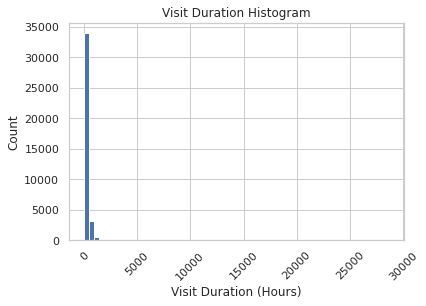

In [8]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
plt.xticks(rotation = 45)
plt.hist(staticDf.visit_duration_hrs, bins=60)

ax.set_title('Visit Duration Histogram')
ax.set_xlabel('Visit Duration (Hours)')
ax.set_ylabel('Count')

### Visit distribution

Text(0.5, 0, 'Visit')

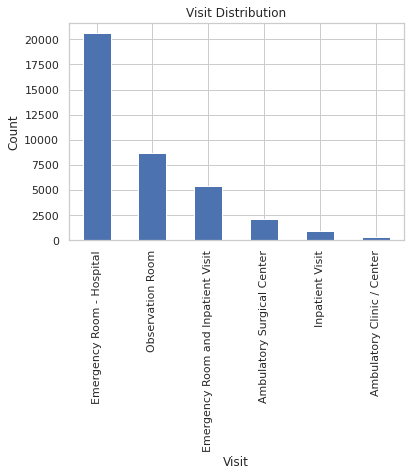

In [9]:
fig, ax = plt.subplots()
plt.xticks(rotation = 90)
staticDf.visit_occurrence_concept_name.value_counts().plot(kind='bar')

ax.set_title('Visit Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('Visit')

### Visit source distribution

Text(0.5, 0, 'Visit Source')

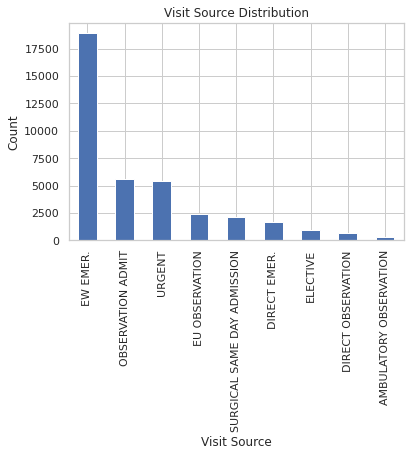

In [10]:
fig, ax = plt.subplots()
plt.xticks(rotation = 90)
staticDf.visit_source_concept_name.value_counts().plot(kind='bar')

ax.set_title('Visit Source Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('Visit Source')

### Admitting source distribution

Text(0.5, 0, 'Admitting Source')

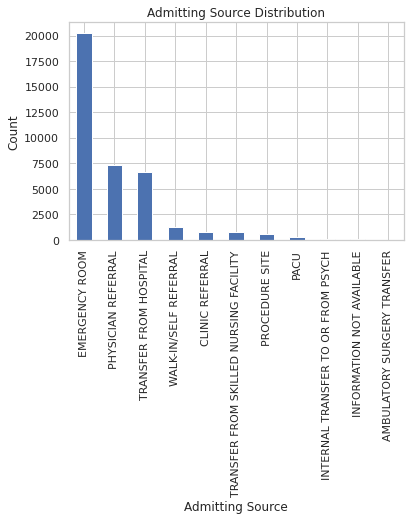

In [11]:
fig, ax = plt.subplots()
plt.xticks(rotation = 90)
staticDf.admitting_source_value.value_counts().plot(kind='bar')

ax.set_title('Admitting Source Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('Admitting Source')

## Vitals data

In [12]:
vitalsQuery = """select * from sepsis_icd.vitals;"""
vitalsDf = pd.read_sql_query(vitalsQuery, con)
vitalsDf

,visit_occurrence_id,person_id,measurement_datetime,unit_source_value,value_as_number,concept_name,rn
0,-914415209,-2146573171,2141-09-15 19:31:00,°F,97.6,Body temperature,1
1,-914415209,-2146573171,2141-09-16 00:00:00,°F,98.3,Body temperature,2
2,-914415209,-2146573171,2141-09-16 04:00:00,°F,97.6,Body temperature,3
3,-914415209,-2146573171,2141-09-16 08:00:00,°F,99.3,Body temperature,4
4,-914415209,-2146573171,2141-09-16 12:00:00,°F,100.1,Body temperature,5
...,...,...,...,...,...,...,...
23214903,741509696,2147343185,2113-08-23 13:01:00,mmHg,127.0,Systolic blood pressure by Noninvasive,98
23214904,741509696,2147343185,2113-08-23 14:01:00,mmHg,124.0,Systolic blood pressure by Noninvasive,99
23214905,741509696,2147343185,2113-08-23 14:01:00,mmHg,124.0,Systolic blood pressure by Noninvasive,100
23214906,741509696,2147343185,2113-08-23 15:01:00,mmHg,116.0,Systolic blood pressure by Noninvasive,101


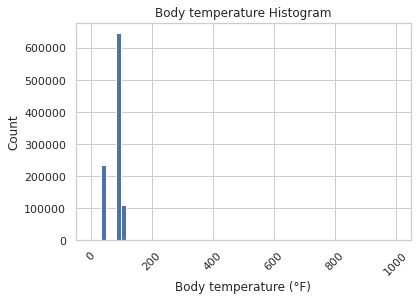

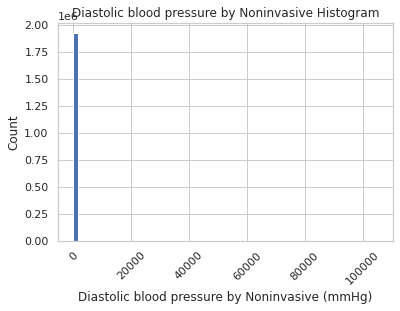

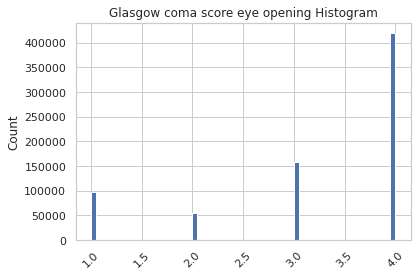

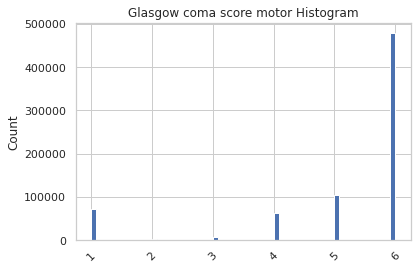

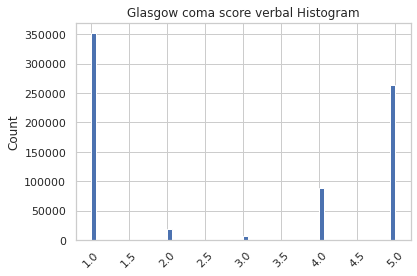

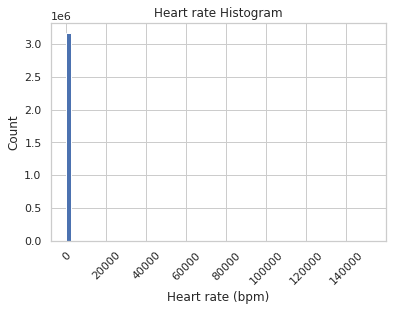

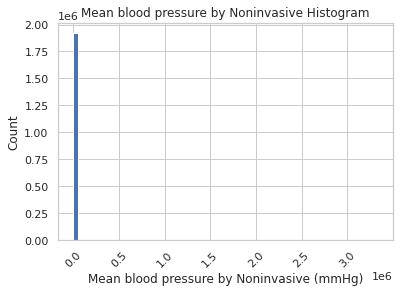

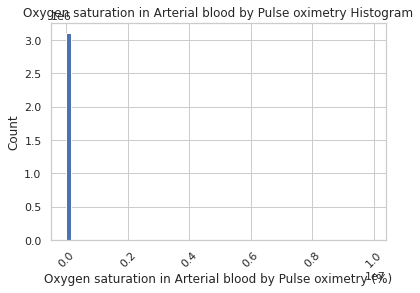

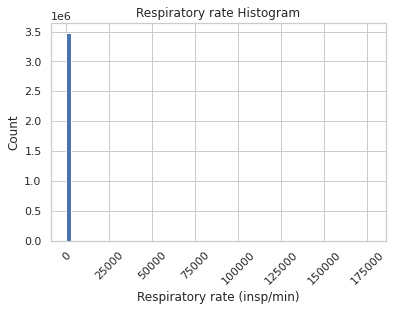

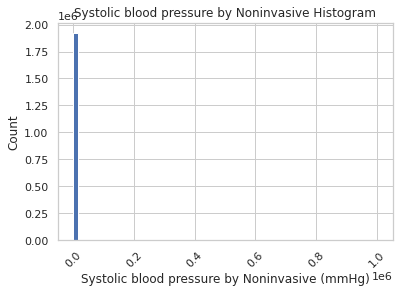

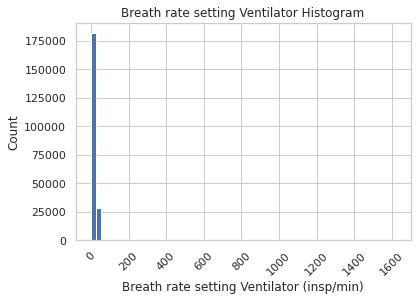

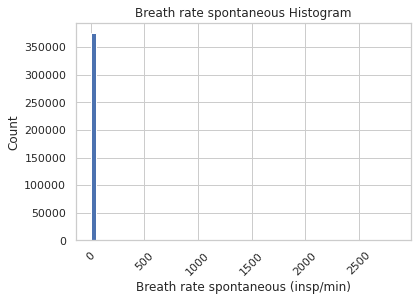

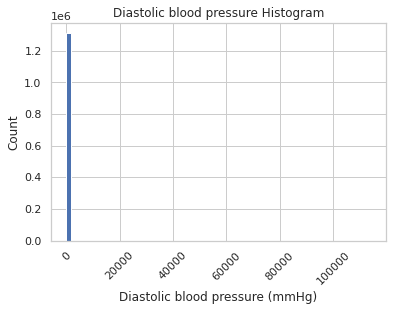

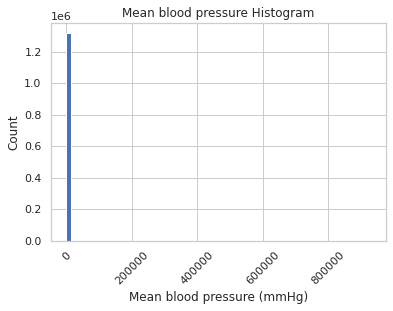

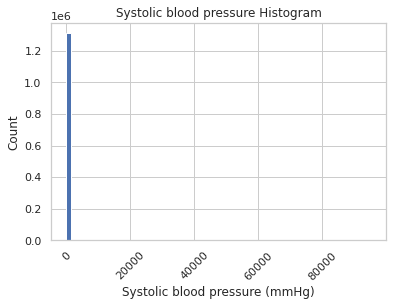

In [38]:
vitalsNames = vitalsDf.concept_name.unique()

for v in vitalsNames:

    fig, ax = plt.subplots()
    plt.xticks(rotation = 45)
    plt.hist(vitalsDf[vitalsDf.concept_name == v].value_as_number, bins=60)

    unit = vitalsDf[vitalsDf.concept_name == v].unit_source_value.tolist()[0]
    unit = (' (' + unit + ')') if unit else ''
    ax.set_title(v + ' Histogram')
    ax.set_xlabel(v + unit)
    ax.set_ylabel('Count')

## Laboratory Measurements

In [39]:
labsQuery = """select * from sepsis_icd.labs;"""
labsDf = pd.read_sql_query(labsQuery, con)
labsDf

,visit_occurrence_id,person_id,measurement_datetime,unit_source_value,value_as_number,concept_name,rn
0,-914415209,-2146573171,2141-09-16 04:26:00,mEq/L,26.0,Bicarbonate [Moles/volume] in Serum or Plasma,1
1,-914415209,-2146573171,2141-09-16 04:26:00,mEq/L,108.0,Chloride [Moles/volume] in Serum or Plasma,1
2,-914415209,-2146573171,2141-09-16 04:26:00,mg/dL,0.7,Creatinine [Mass/volume] in Serum or Plasma,1
3,-914415209,-2146573171,2141-09-16 04:26:00,mg/dL,74.0,Glucose [Mass/volume] in Serum or Plasma,1
4,-914415209,-2146573171,2141-09-16 04:26:00,g/dl,9.3,Hemoglobin [Mass/volume] in Blood,1
...,...,...,...,...,...,...,...
1414251,741509696,2147343185,2113-08-21 03:55:00,mEq/L,141.0,Sodium [Moles/volume] in Serum or Plasma,1
1414252,741509696,2147343185,2113-08-21 08:19:00,mEq/L,139.0,Sodium [Moles/volume] in Serum or Plasma,2
1414253,741509696,2147343185,2113-08-21 16:30:00,mEq/L,137.0,Sodium [Moles/volume] in Serum or Plasma,3
1414254,741509696,2147343185,2113-08-22 01:34:00,mEq/L,136.0,Sodium [Moles/volume] in Serum or Plasma,4


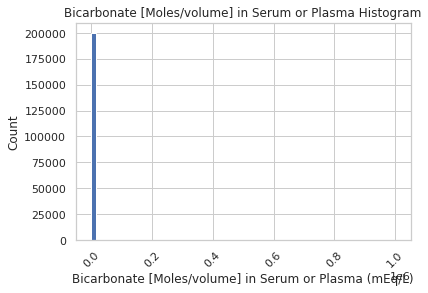

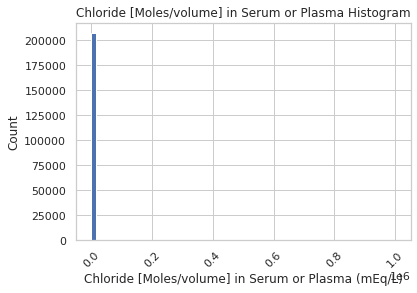

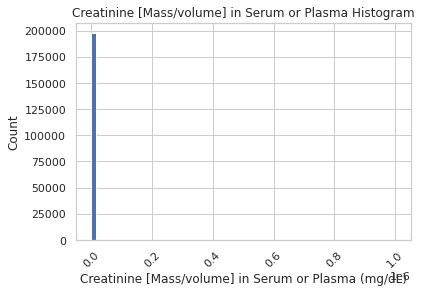

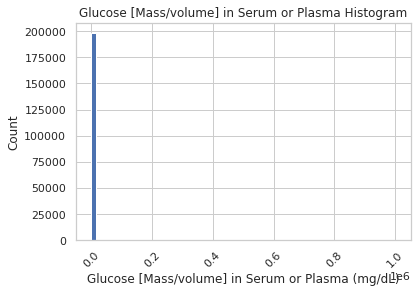

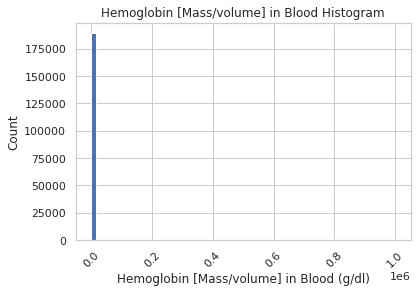

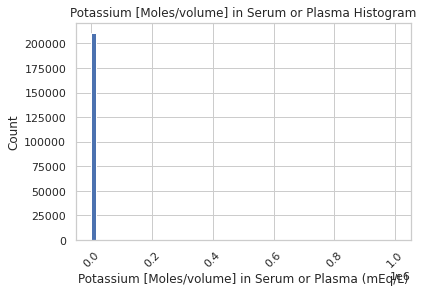

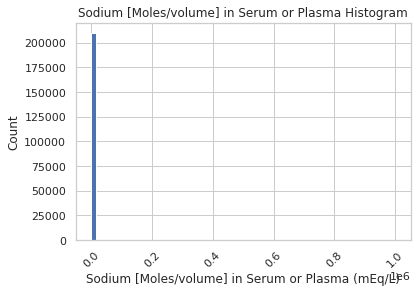

In [43]:
labsNames = labsDf.concept_name.unique()

for v in labsNames:

    fig, ax = plt.subplots()
    plt.xticks(rotation = 45)
    plt.hist(labsDf[labsDf.concept_name == v].value_as_number, bins=60)

    unit = labsDf[labsDf.concept_name == v].unit_source_value.tolist()[0]
    unit = (' (' + unit + ')') if unit else ''
    ax.set_title(v + ' Histogram')
    ax.set_xlabel(v + unit)
    ax.set_ylabel('Count')

## Mortality Data

In [44]:
mortalityQuery = """select * from sepsis_icd.mortality;"""
mortalityDf = pd.read_sql_query(mortalityQuery, con)
mortalityDf

,visit_occurrence_id,person_id,discharge_mortality,one_day_mortality,two_day_mortality,thirty_day_mortality,sixty_day_mortality,ninety_day_mortality
0,-2147462198,-421334407,False,False,False,False,False,False
1,-2147446567,-231498446,False,False,False,False,False,False
2,-2147304039,1052438339,False,False,False,False,False,False
3,-2147110420,-322699580,True,True,True,True,True,True
4,-2147002424,-1242295740,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
38079,2147093477,-1280183440,False,False,False,False,False,False
38080,2147189942,-1302532301,False,False,False,False,False,False
38081,2147275831,-1025184208,True,True,True,True,True,True
38082,2147336854,1307988051,False,False,False,False,False,False


In [49]:
mortalityData = []
mortalityData.append(['Discharge Mortality', mortalityDf.discharge_mortality.sum()])
mortalityData.append(['One Day Mortality', mortalityDf.one_day_mortality.sum()])
mortalityData.append(['Two Day Mortality', mortalityDf.two_day_mortality.sum()])
mortalityData.append(['Thirty Day Mortality', mortalityDf.thirty_day_mortality.sum()])
mortalityData.append(['Sixty Day Mortality', mortalityDf.sixty_day_mortality.sum()])
mortalityData.append(['Ninety Day Mortality', mortalityDf.ninety_day_mortality.sum()])

In [50]:
plotDf = pd.DataFrame(mortalityData, columns=["mortality_class", "cnt"])
plotDf

,mortality_class,cnt
0,Discharge Mortality,4158
1,One Day Mortality,4203
2,Two Day Mortality,4213
3,Thirty Day Mortality,4512
4,Sixty Day Mortality,4759
5,Ninety Day Mortality,4922


Text(0.5, 0, 'Mortality Class')

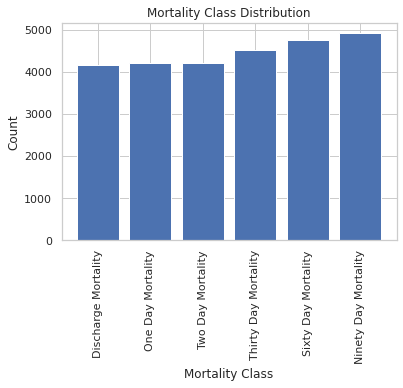

In [51]:
fig, ax = plt.subplots()
plt.xticks(rotation = 90)
plt.bar(x=plotDf.mortality_class, height=plotDf.cnt)

ax.set_title('Mortality Class Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('Mortality Class')